In [1]:
!pip install -q gdown

In [2]:
import gc
import glob
import pandas
import numpy as np

from math import ceil

import lightgbm as lgb
from xgboost import XGBRanker
from lightgbm.sklearn import LGBMRanker

from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

try: import cudf; GPU = True
except: GPU = False
    
from tqdm import tqdm
tqdm.pandas() # progress_map, progress_apply ...

In [3]:
if not os.path.exists('models'):
    os.mkdir('models')

# * Краткое описание датасетов *

__otto-last-items__ - датасет с историей.

* lastItems - история. __[session, type, labels(list:int)]__
* popular - популярные файлы. __[type, labels(list:int)]__
* extended - не нужно. Данные для мержа истории. Добавленны отсутствующие событиями (копированием 0->1->2).

__otto-577-candidates__ - датасет с матрицами
* toMatrix_clicks_40 - 40 кандидатов для кликов. __[session, type, hist, count, labels(list)]__
    * hist - сколько первых кандидатов являются историей
    * count - всего кандидатов

# * Полезные функции *

In [4]:
def groupType(x):
    res = list(set(x))
    return sum(res) if len(res) > 0 else -1
# -----------------------------------------------------------
def groupLen(x):
    return len(list(set(x)))
# -----------------------------------------------------------
def fillEvents(df, clone=True, value=[-1]):
    result = pd.DataFrame()
    _ = df[['session','type']].groupby(['session']).agg(ctype = ('type', groupType), count = ('type', groupLen))
    
    tmp = df[df['session'].isin(_[_['ctype'] == 0].index)].copy()
    if not clone: tmp['aid'] = tmp['aid'].apply(lambda x: value)
    tmp['type'] = 1
    result = pd.concat([result, tmp])
    tmp['type'] = 2
    result = pd.concat([result, tmp])

    tmp = df[df['session'].isin(_[_['ctype'] == 1].index)].copy().drop_duplicates(['session'])
    if not clone: tmp['aid'] = tmp['aid'].apply(lambda x: value)
    tmp['type'] = 2
    result = pd.concat([result, tmp])

    tmp = df[df['session'].isin(_[_['ctype'] == 2].index)].copy().drop_duplicates(['session'])
    if not clone: tmp['aid'] = tmp['aid'].apply(lambda x: value)
    tmp['type'] = 1
    result = pd.concat([result, tmp])
    
    tmp = df[df['session'].isin(_[(_['ctype'].isin([1, 2]))&(_['count'] == 1)].index)].copy()
    if not clone: tmp['aid'] = tmp['aid'].apply(lambda x: value)
    tmp['type'] = 0
    result = pd.concat([result, tmp])

    tmp = df[df['session'].isin(_[(_['ctype'] == 3)&(_['count'] == 2)].index)].copy()\
                .drop_duplicates(['session'])
    if not clone: tmp['aid'].apply(lambda x: [])
    tmp['type'] = 0
    result = pd.concat([result, tmp])

    return pd.concat([df, result]).astype({'session':'uint32', 'type':'uint8'})
# -----------------------------------------------------------
def cloneEvents(df):
    df['type'] = 0
    _ = df.copy()
    _['type'] = 1
    df = pd.concat([df, _])
    _['type'] = 2
    return pd.concat([df, _]).astype({'type': 'uint8'})

In [5]:
# ----------------------------------------------
def removeFiles(mask='*'):
    for file in glob.glob('*'):
        print('remove', '-'*10, file)
        os.remove(file)
# ----------------------------------------------
def explodeLabels(*, df = None, path = None, rename=True):
    if path is not None: df = pd.read_parquet(path)
    if 'labels' not in df.columns: return df
    if type(df.iloc[0]['labels']) is str:
        if GPU: df = df.to_pandas()
        df['labels'] = df['labels'].progress_apply(lambda x: [np.uint32(i) for i in x.split(' ')])
        if GPU: df = pd.from_pandas(df)
    df = df.explode('labels').astype({'labels': 'uint32'})
    if rename: df = df.rename(columns={'labels':'aid'})
    return df.reset_index(drop=True)
# ----------------------------------------------
def googleDownload(file_id, filename=None):
    import gdown
    import shutil
    gdown.download(f'https://drive.google.com/u/0/uc?id={file_id}', filename, quiet=False)
    if filename.find('.zip') > -1:
        shutil.unpack_archive(filename, format='zip')
        os.remove(filename)
# ----------------------------------------------
def getHistoryFromCandidates(df):
    df['n'] = df.groupby('session').cumcount()
    df = df.loc[df['n'] < df['hist']].drop('n', axis=1)
    return df
# ------------------------------------------------------
def loadTestLabels(path='/kaggle/input/otto-train-and-test-data-for-local-validation/', p=1.0):
    df = pd.read_parquet(f'{path}test_labels.parquet')
    if 'aid' in df.columns:
        if GPU: df = df.to_pandas()
        df = df.groupby(['session', 'type']).agg(labels=('aid', lambda x: list(dict.fromkeys(x))[:20]))
        if GPU: df = pd.from_pandas(df)
        df = df.reset_index()
    elif 'ground_truth' in df.columns:
        df['type'] = df['type'].map({'clicks':0, 'carts':1, 'orders':2}).astype('uint8')
        df = df.rename(columns={'ground_truth':'labels'})
    if p < 1: df['labels'] = df['labels'].progress_apply(lambda x: x[-ceil(len(x) * p):])
    return df
# ------------------------------------------------------
def localMetrics(sub, df_true=None, load=loadTestLabels, *, drop=False, recall=True, epoch=False):
    # -- load ground truth
    if df_true is None: df_true=load()
    
    # -- calculate metrics
    test_labels = pd.merge(df_true, sub, how='left', on=['session', 'type'])
    if drop: test_labels.dropna(inplace=True)
    else: test_labels.fillna('', inplace=True)

    if GPU: test_labels     = test_labels.to_pandas()
    test_labels['hits']     = test_labels.progress_apply(lambda df: len(set(df['labels_x']).intersection(set(df['labels_y'][:20]))), axis=1)
    if recall:
        test_labels['rhits']    = test_labels.progress_apply(lambda df: len(set(df['labels_x']).intersection(set(df['labels_y']))), axis=1)
    if GPU: test_labels     = pd.from_pandas(test_labels)
    test_labels['gt_count'] = test_labels['labels_x'].str.len().clip(0,20)  
    
    print('-' * 50)
    recall_per_type = test_labels.groupby(['type'])['hits'].sum() / test_labels.groupby(['type'])['gt_count'].sum() 
    score = (recall_per_type * pd.Series({0: 0.10, 1: 0.30, 2: 0.60})).fillna(0)
    print(f"{score.sum():.3f} = {score[0]:.3f} + {score[1]:.3f} + {score[2]:.3f}")
    print('score:', score.sum())
    
    if recall:
        print('-' * 50)
        recall_per_type = test_labels.groupby(['type'])['rhits'].sum() / test_labels.groupby(['type'])['gt_count'].sum() 
        score = (recall_per_type * pd.Series({0: 0.10, 1: 0.30, 2: 0.60})).fillna(0)
        print(f"{score.sum():.3f} = {score[0]:.3f} + {score[1]:.3f} + {score[2]:.3f}")
        print('recall:', score.sum())
        
    return round(score, 4) if epoch else test_labels
# ------------------------------------------------------
def get_groups(df, column='gt'):
    return df.groupby('session')[column].count().sort_index().values
# ----------------------------------------------
def splitDataFrame(df, *, p=0.9, t=None):
    if t is not None:
        train_cutoff = df['ts'].max() - t
        train = df[df['ts'] <= train_cutoff]
        test = df[df['ts'] > train_cutoff].copy()
    else:
        df['n'] = df.groupby('session').cumcount()
        group = df.groupby('session')['n']
        train_cutoff = (group.max()*p).rename('ts_agg').astype('uint8')
        train = pd.merge(df, train_cutoff, how='left', on='session')
        test = train[train['n'] > train['ts_agg']].drop(['n', 'ts_agg'], axis=1)
        train = train[train['n'] <= train['ts_agg']].drop(['n', 'ts_agg'], axis=1)
    return train, test
# ----------------------------------------------
def loadTrainData(path, *, p=1.0):
    if path.find('.csv') > -1:
        df = pd.read_csv(path)
    elif path.find('.parquet') > -1 or path.find('.pqt') > -1:
        df = pd.read_parquet(path)
    if p < 1: df = df.sample(n=int(len(df)*p))
    return df
# ----------------------------------------------
def setGroundTruth(df, labels):
    df = df.merge(labels, on=['session', 'aid', 'type'], how='left')
    #tmp = df[df['gt'].isna()]
    #df['gt'].dropna(inplace=True)
    if len(df) < 2: return None
    #if len(tmp) > 0:
    #    df = pd.concat([df, tmp.sample(n=min(len(df), len(tmp)))])
    df['gt'].fillna(0, inplace=True)
    return df.astype({'gt':'uint16'})
# ----------------------------------------------
def prepareTest(*, df=None, path=None, fill=True, clone=True):
    if df is None: df = pd.read_parquet(path)
    if fill: df = fillEvents(df, clone)
    return df
# ------------------------------------------------------
def setSubmission(df):
    df = df.copy()
    df['type'] = df['type'].map({0:'clicks', 1:'orders', 2:'carts'})
    df['session_type'] = df['session'].astype('str') + '_' + df['type']
    if GPU: df = df.to_pandas()
    df['labels'] = df['labels'].fillna('').progress_apply(lambda x: ' '.join(str(i) for i in x))
    if GPU: df = pd.from_pandas(df)
    return df.drop(['session', 'type'], axis=1)
# ------------------------------------------------------
def loadTestDataset(*, path='/kaggle/input/otto-full-optimized-memory-footprint/test.parquet', p=0.1):
    df = pd.read_parquet(path)
    #__, df = splitDataFrame(df, t=7*24*60*60)
    train, test = splitDataFrame(df, p=1-p)
    return train, test
# ------------------------------------------------------
def getHistory(*, df=None, path=None, n=20):
    if path is not None: df = pd.read_parquet(path)
    df = df.sort_values('ts', ascending=True)
    df.drop_duplicates(['session', 'aid'], inplace=True)
    df['n'] = df.groupby(['session', 'type']).cumcount()
    df = df.loc[df['n']<20].drop('n', axis=1)
    if GPU: df = df.to_pandas()
    df = df.groupby(['session', 'type']).agg(labels=('aid', lambda x: list(dict.fromkeys(x))[:n]))
    if GPU: df = pd.from_pandas(df)
    return df.reset_index()
# ------------------------------------------------------
def prepareCandidates(path, *, p=1.0, t=0):
    df = pd.read_csv(path)
    if GPU: df = df.to_pandas()
    df['labels'] = df['labels'].progress_apply(lambda x: [np.uint32(i) for i in x.split(' ')])
    if GPU: df = pd.from_pandas(df)
    df['type'] = t
    return df.astype({'session':'uint32', 'type':'uint8'})

# * Валидатор *

In [6]:
def validate_ds(sessions, candidates, scores, prod_type, check_history=20, *, df_true=None):
    df = pd.DataFrame({'session': sessions, 'cand': candidates, 'scores': scores})    
    df = df.sort_values(['session','scores'],ascending=[True,False]).groupby('session')\
        .process_apply(lambda x: list(x.cand)[:check_history]).reset_index(name='labels')
    df['type'] = prod_type
    result = validate_submission_df(df, check_history, df_true)
    return result[prod_type]

def validate_submission_df(submission, check_history = 20, *, test_labels=None, load=None):
    if test_labels is None: test_labels=load()
    test_labels_m = test_labels.merge(submission, how='left', on=['session', 'type'])
    test_labels_m = test_labels_m[test_labels_m.labels.notnull()] # if PART < 1.0
    test_labels_m['hits'] = test_labels_m.process_apply(lambda df: len(set(df.ground_truth).intersection(set(df.labels))), axis=1)
    test_labels_m['gt_count'] = test_labels_m.ground_truth.str.len().clip(0,20)

    recall_per_type = test_labels_m.groupby(['type'])['hits'].sum() / (test_labels_m.groupby(['type'])['gt_count'].sum())
    recall = recall_per_type.sum()

    score = (recall_per_type * pd.Series({'clicks': 0.10, 'carts': 0.30, 'orders': 0.60})).sum()

    recall_per_type_weighted = recall_per_type * pd.Series({'clicks': 0.10, 'carts': 0.30, 'orders': 0.60})
    recall_per_type_no_weighted = recall_per_type * pd.Series({'clicks': 1.0, 'carts': 1.0, 'orders': 1.0})

    score = recall_per_type_weighted.sum()
    
    result = {
        'score': score,
        'recall': recall,        
        'clicks': {
            'score':  recall_per_type_weighted[1],
            'recall': recall_per_type_no_weighted[1]
        },
        'carts': {
            'score':  recall_per_type_weighted[0],
            'recall': recall_per_type_no_weighted[0]
        },
        'orders': {
            'score':  recall_per_type_weighted[2],
            'recall': recall_per_type_no_weighted[2]
        },
    }
    return result

# * Фичи *

In [7]:
# == Глобальные фичи ================================================
# =========================== Basic =================================
def fSession(df):
    return 'session', df
# -----------------------------------------------------
def fAid(df):
    return 'aid', df
# -----------------------------------------------------
def fType(df):
    return 'type', df
# -----------------------------------------------------
def fts(df):
    return 'ts', df

# =========================== Prepare V1 (History) ========================
# == session_length, action_num_reverse_chrono, log_recency_score, type_weighted_log_recency_score
def session_length(df):
    # Длина сессии по количеству событий
    return 'session_length', df
# -----------------------------------------------------
def action_num_reverse_chrono(df):
    # реверсивный порядок событий
    return 'action_num_reverse_chrono', df
# -----------------------------------------------------
def log_recency_score(df):
    # логарифмический порядок событий 
    return 'log_recency_score', df
# -----------------------------------------------------
def type_weighted_log_recency_score(df):
    # логарифмический порядок событий с весами по типам
    return 'type_weighted_log_recency_score', df

# =========================== Prepare V2 =================================
# == item_item_count, item_user_count, item_buy_ratio, user_item_count, user_buy_ratio, bought_in_session
def item_item_count(df):
    # сколько раз товар встречался во всех сессиях
    return 'item_item_count', df
# -----------------------------------------------------
def item_user_count(df):
    # в скольких сессиях встречался товар
    return 'item_user_count', df
# -----------------------------------------------------
def item_buy_ratio(df):
    # коэфициент покупки товара (type, mean)
    return 'item_buy_ratio', df
# -----------------------------------------------------
def user_item_count(df):
    # со сколькми уникальными товарами взаимодействовал пользователь
    return 'user_item_count', df
# -----------------------------------------------------
def user_buy_ratio(df):
    # коэфициент покупки пользователя  (type, mean)
    return 'user_buy_ratio', df
# -----------------------------------------------------
def bought_in_session(df):
    # был ли товар куплен в рамках сессии
    return 'bought_in_session', df

# =========================== Prepare V3 =================================
# == aid_clicked_count, aid_carted_count, aid_ordered_count, sec_to_session_end, sec_since_session_start
def aid_clicked_count(df):
    # сколько товар был кликнут
    return 'aid_clicked_count', df
# -----------------------------------------------------
def aid_carted_count(df):
    # сколько товар был положен в корзину
    return 'aid_carted_count', df
# -----------------------------------------------------
def aid_ordered_count(df):
    # сколько товар был куплен
    return 'aid_ordered_count', df
# -----------------------------------------------------
def sec_to_session_end(df):
    # секунд до конца сессии
    return 'sec_to_session_end', df
# -----------------------------------------------------
def sec_since_session_start(df):
    # секунд с начала сессии
    return 'sec_since_session_start', df


# =========================== Prepare V4 =================================
# == this_aid_clicked_count, this_aid_carted_count, this_aid_ordered_count, onehot_clicks, onehot_carts, onehot_orders
def this_aid_clicked_count(df):
    # сколько товар был кликнут в рамках сессии
    return 'this_aid_clicked_count', df
# -----------------------------------------------------
def this_aid_carted_count(df):
    # сколько товар был положен в корзину в рамках сессии
    return 'this_aid_carted_count', df
# -----------------------------------------------------
def this_aid_ordered_count(df):
    # сколько товар был куплен в рамках сессии
    return 'this_aid_ordered_count', df
# -----------------------------------------------------
def onehot_clicks(df):
    return 'onehot_clicks', df
# -----------------------------------------------------
def onehot_carts(df):
    return 'onehot_carts', df
# -----------------------------------------------------
def onehot_orders(df):
    return 'onehot_orders', df


# =========================== Prepare V5 =================================
# == clicks_user_counter, carts_user_counter, orders_user_counter, clicks_timed_global_counter, carts_timed_global_counter, orders_timed_global_counter
def clicks_user_counter(df):
    # в скольких сессия был кликнут товар
    return 'clicks_user_counter', df
# -----------------------------------------------------
def carts_user_counter(df):
    # в скольких сессия был положен в корзину товар
    return 'carts_user_counter', df
# -----------------------------------------------------
def orders_user_counter(df):
    # в скольких сессия был куплен товар
    return 'orders_user_counter', df
# -----------------------------------------------------
def clicks_timed_global_counter(df):
    # количество кликов с весами по времени
    return 'clicks_timed_global_counter', df
# -----------------------------------------------------
def carts_timed_global_counter(df):
    # количество корзин с весами по времени
    return 'carts_timed_global_counter', df
# -----------------------------------------------------
def orders_timed_global_counter(df):
    # количество покупок с весами по времени
    return 'orders_timed_global_counter', df
# -----------------------------------------------------
def user_carts_clicks_ratio(df):
    # количество покупок с весами по времени
    return 'user_carts_clicks_ratio', df
# -----------------------------------------------------
def user_orders_carts_ratio(df):
    # количество покупок с весами по времени
    return 'user_orders_carts_ratio', df
# -----------------------------------------------------
def user_orders_clicks_ratio(df):
    # количество покупок с весами по времени
    return 'user_orders_clicks_ratio', df
# -----------------------------------------------------
def user_events(df):
    # количество событий пользователя
    return ['user_clicks', 'user_carts', 'user_orders'], df
# -----------------------------------------------------
def user_ratio(df):
    # соотношение кликов/покупок/корзин пользователя (type, mean)
    return ['user_carts_clicks_ratio', 'user_orders_carts_ratio', 'user_orders_clicks_ratio'], df

#	covisit_clicks_candidate_num		0.24848206202059703
#	covisit_buys_candidate_num 			0.009287900880354305
#	aid_interacted_with_count 			0.004570131040186471
#	relative_position_in_session 		0.00021918611998695227
#	popularity_0 						0.0
#	popularity_1 						0.0
#	popularity_2 						0.0
# -----------------------------------------------------

# * Пайплайн * 

In [8]:
def callPipeline(df, pipeline):
    ft = []
    if type(pipeline) is list:
        for func in pipeline:
            result, df = func(df)
            if result is not None:
                ft.extend(result if type(result) is list else [result])
        return ft, df
    else: return pipeline(df)
# -----------------------------------------------------
def runPipeline(df, pipeline):
    ft = []
    for func in pipeline:
        try:
            result, df = func(df)
            if result is not None: ft.append(result)
        except:
            print(func, 'is not feature')
    return ft, df
# -----------------------------------------------------   
def Example(df):
    pipeline = [fSession, fAid]
    ft, df = callPipeline(df, pipeline)
    return ft, df
# ----------------------------------------------------- 
def sessionPipline(df):
    pipeline = [session_length, user_item_count, user_buy_ratio, user_events, user_ratio]
    ft, df = callPipeline(df, pipeline)
    return ft, df
# -----------------------------------------------------
def aidPipline(df):
    pipeline = [clicks_user_counter, carts_user_counter, orders_user_counter, clicks_timed_global_counter, carts_timed_global_counter, 
                orders_timed_global_counter, aid_clicked_count, aid_carted_count, aid_ordered_count, item_item_count, item_user_count, item_buy_ratio]
    ft, df = callPipeline(df, pipeline)
    return ft, df
# -----------------------------------------------------
def session_aidPipline(df):
    pipeline = [this_aid_clicked_count, this_aid_carted_count, this_aid_ordered_count, sec_to_session_end, sec_since_session_start, 
               action_num_reverse_chrono, onehot_clicks, onehot_carts, onehot_orders] # bought_in_session
    ft, df = callPipeline(df, pipeline)
    return ft, df

# * Конфиг *

In [9]:
# ==================================================================
# ----- Конфигурация модели для экспериментов-----------------------
# ==================================================================
model = {
    'model': LGBMRanker,
    'params': {
        'objective'    : 'lambdarank',
        'boosting_type': 'dart',
        'metric'       : 'ndcg',
        'learning_rate': 0.2,
        'n_estimators' : 20,
        #'max_depth'    : 4,
        #'num_leaves'   : 5, 
    },
    #'epoch'        : 10,
    'show_metric': False, # Показывать ли метрику обучения (train_test_split(0.8, 0.2))
    #'model': XGBRanker,
    #'params': {
    #    'objective'  : 'rank:pairwise',
    #    'eval_metric': 'ndcg',
    #}
}
# ----------------------------------------------------

In [10]:
# ==================================================================
# ----- Конфигурация сессии для экспериментов-----------------------
# ==================================================================
LOCAL = True # Тип метрики. True - локально, False - Kaggle
SHOW  = True # Выводить ли таблицы в процессе
FILL  = False # Клонировать предсказания 0->1->2, если не хватает событий
indx  = 'session_aid_more'
# ----------------------------------------------------
params = {
    'dataset': [
        {'gid':'1nuwf_giPfZkJZc-FZVJmNiaNStUH1BFv', 'filename':'candidates.zip', 'path':'orders_candidates.csv'},
        #{ 'path': '/kaggle/input/otto-last-items/local_lastItems.parquet'}, # 0.481
        #{ 'path': 'test.parquet'}
    ],
    'download_dataset': False, # нужно ли загружать данные с диска
    'prepare_dataset': False,  # подготавливать ли датасет
    'dataset_sample': 1.0,     # размер загружаемого датасета
    'prepare_features': False,  # вычислять ли фичи
    
    'features_dataset': '/kaggle/input/otto-train-features',
    'use_train_features': True, # использовать фичи вычисленные в train
    'use_blank_features': False,
    
    'train_model': True,       # обучать ли модель
    'save_model': True,        # сохранять ли модель
    'use_model': True,         # использовать ли модель для предсказания
    'chunks': 10,

    'force_ranking': False, # обучать отдельные модели для кликов, корзин и покупок

    'pipeline': [sessionPipline, aidPipline, session_aidPipline],
    'target': 'gt',
    
    'test_dataset': '/kaggle/input/otto-full-optimized-memory-footprint/test.parquet',
    'calculate_test': False,
    'test_sample': 0.3,
    
     #'get_history': False,
}
# ----------------------------------------------------
pd = cudf if GPU else pandas
print('We will use RAPIDS version',cudf.__version__) if GPU else print('We will use CPU', '...')

We will use CPU ...


# * Загрузка данных с диска *

In [14]:
%%time
# ~ 25s (order candidates)
if params.get('download_dataset'):
    for dataset in params['dataset']:
        if 'gid' in dataset.keys():  
            googleDownload(dataset.get('gid'), dataset.get('filename'))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.3 µs


# * Подготовка датасета и фич *

In [15]:
%%time
# -- подготовка валидатора 
# ~ 7s
if params['calculate_test']:
    train = pd.read_parquet(params['test_dataset'])
    train, test = loadTestDataset(path=params['test_dataset'], p=params['test_sample'])
    train.to_parquet('test.parquet')
    test.drop('ts', axis=1).to_parquet('test_labels.parquet')
    if SHOW: display(train.head(2), test.head(2))
    del train, test; gc.collect()

#_ = pd.read_parquet('/kaggle/input/otto-train-and-test-data-for-local-validation/test.parquet').sort_values(['session', 'type'])
#max = _['session'].max()
#min = _['session'].min()
#_.loc[_['session'] > (max - min) * 0.9 + min].sort_values(['session', 'type'])

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 10.5 µs


In [16]:
%%time
# -- подготовка истории
# ~s
#if params['get_history']:
#    history = getHistory(path='test.parquet', n=20)
#    history.to_parquet('history.parquet', index=False)
#    if SHOW: display(history.head(4))
#    del history; gc.collect()

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.34 µs


In [17]:
%%time
# -- разбиваем все датасеты на файлы по сессиям (сессиий в файлах не пересекаются) --
# ~ 40m (order candidates)
if params.get('prepare_dataset') != False:
    for j, dataset in enumerate(params['dataset']):
        print("process '", dataset['path'], "' ...")
        train = loadTrainData(dataset['path'], p=params.get('dataset_sample') or 1.0)
        start, end = train['session'].min(), train['session'].max()
        ln = ceil((end - start) / params['chunks'])
        for i in range(0, params['chunks']):
            s = start + i*ln
            e = min(start + (i+1)*ln, end + 1)
            if e == end: e += 1
            print('\r', f'chunk {i+1} of {params["chunks"]} ({s} to {e-1})')#, end='   ')
            __ = train[(train['session']>=s)&(train['session']<e)]
            __ = explodeLabels(df=__)
            if j == 0: __.to_parquet(f'train_{i}.parquet', index=False)
            else:
                tmp = pd.read_parquet(f'train_{i}.parquet')
                __ = pd.concat([tmp, __])
                __.to_parquet(f'train_{i}.parquet', index=False)

        if SHOW and i == params['chunks'] -1: display(__.head(4))
        del train; gc.collect()

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 10.7 µs


In [13]:
%%time
# -- вычисляем фичи для каждого файла --
# ~ Example 2s
if params.get('prepare_features') != False:
    for i in range(0, params['chunks']):
        train = explodeLabels(path=f'train_{i}.parquet')
        s, e = train['session'].min(), train['session'].max()
        print('\r', f'chunk {i+1} of {params["chunks"]} ({s} to {e})')#, end = '   ')
        __, train = callPipeline(train, params['pipeline'])
        train.to_parquet(f'train_{i}f.parquet', index=False)
    if SHOW and i == params['chunks'] -1: display(train.head(4))
    #del train; gc.collect()

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 10.7 µs


In [76]:
%%time
# -- загружаем фичи из файла --
# ~ 20m (order candidates)
if params.get('use_train_features') != False:
    features, __ = callPipeline(None, params['pipeline'])
    features.extend(['session', 'aid'])
    for k, t in enumerate(['aid', 'session']):
        feat = []
        ftrain = loadTrainData(path=params['features_dataset'] + f'/features_{t}.parquet')
        for i in features:
            if i in ftrain.columns:
                feat.append(i)
        if len(feat) > 0:
            on = [t] if t in ['session', 'aid'] else ['session', 'aid']
            for i in range(0, params['chunks']):
                train = loadTrainData(path=f'train_{i}.parquet') if k == 0 else loadTrainData(path=f'train_{i}f.parquet')
                s, e = train['session'].min(), train['session'].max()
                print('\r', f'chunk {i+1} of {params["chunks"]} ({s} to {e})')#, end = '   ')
                train = train.merge(ftrain, how='left', on=on)
                train.fillna(0, inplace=True)
                train.to_parquet(f'train_{i}f.parquet', index=False)
            if SHOW and i == params['chunks'] -1: display(train.head(4))
    #del train; gc.collect()

 chunk 1 of 10 (11098528 to 11278652)
 chunk 2 of 10 (11278653 to 11458777)
 chunk 3 of 10 (11458778 to 11638902)
 chunk 4 of 10 (11638903 to 11819027)
 chunk 5 of 10 (11819028 to 11999152)
 chunk 6 of 10 (11999153 to 12179277)
 chunk 7 of 10 (12179278 to 12359402)
 chunk 8 of 10 (12359403 to 12539527)
 chunk 9 of 10 (12539528 to 12719652)
 chunk 10 of 10 (12719653 to 12899778)


,session,aid,clicks_user_counter,carts_user_counter,orders_user_counter,clicks_timed_global_counter,carts_timed_global_counter,orders_timed_global_counter,aid_clicked_count,aid_carted_count,aid_ordered_count,item_item_count,item_user_count,item_buy_ratio
0,12719653,1022566,6476.0,1468.0,626.0,1181.120483,222.917664,75.473892,11541.0,2023.0,721.0,14285.0,6524.0,0.242562
1,12719653,544144,4431.0,1057.0,409.0,946.068298,174.283127,48.839359,8280.0,1522.0,456.0,10258.0,4467.0,0.237278
2,12719653,166037,7970.0,1868.0,777.0,1580.957886,293.008026,87.640564,14901.0,2687.0,863.0,18451.0,8018.0,0.239174
3,12719653,102416,1127.0,346.0,166.0,230.200806,56.987953,25.953815,1883.0,436.0,181.0,2500.0,1145.0,0.319200


 chunk 1 of 10 (11098528 to 11278652)
 chunk 2 of 10 (11278653 to 11458777)
 chunk 3 of 10 (11458778 to 11638902)
 chunk 4 of 10 (11638903 to 11819027)
 chunk 5 of 10 (11819028 to 11999152)
 chunk 6 of 10 (11999153 to 12179277)
 chunk 7 of 10 (12179278 to 12359402)
 chunk 8 of 10 (12359403 to 12539527)
 chunk 9 of 10 (12539528 to 12719652)
 chunk 10 of 10 (12719653 to 12899778)


,session,aid,clicks_user_counter,carts_user_counter,orders_user_counter,clicks_timed_global_counter,carts_timed_global_counter,orders_timed_global_counter,aid_clicked_count,aid_carted_count,...,item_buy_ratio,session_length,user_item_count,user_buy_ratio,user_clicks,user_carts,user_orders,user_carts_clicks_ratio,user_orders_carts_ratio,user_orders_clicks_ratio
0,12719653,1022566,6476.0,1468.0,626.0,1181.120483,222.917664,75.473892,11541.0,2023.0,...,0.242562,6,2,0.666667,3,2,1,0.666667,0.5,0.333333
1,12719653,544144,4431.0,1057.0,409.0,946.068298,174.283127,48.839359,8280.0,1522.0,...,0.237278,6,2,0.666667,3,2,1,0.666667,0.5,0.333333
2,12719653,166037,7970.0,1868.0,777.0,1580.957886,293.008026,87.640564,14901.0,2687.0,...,0.239174,6,2,0.666667,3,2,1,0.666667,0.5,0.333333
3,12719653,102416,1127.0,346.0,166.0,230.200806,56.987953,25.953815,1883.0,436.0,...,0.319200,6,2,0.666667,3,2,1,0.666667,0.5,0.333333


 chunk 1 of 10 (11098528 to 11278652)


KeyboardInterrupt: 

In [35]:
%%time
# -- загружаем фичи из файла --
# ~ 20m (order candidates)
if params.get('use_train_features') != False:
    features, __ = callPipeline(None, params['pipeline'])
    features.extend(['session', 'aid'])
    for k, t in enumerate(['session_aid_orders']):
        feat = []
        ftrain = loadTrainData(path=params['features_dataset'] + f'/features_{t}.parquet')
        for i in features:
            if i in ftrain.columns:
                feat.append(i)
        if len(feat) > 0:
            on = [t] if t in ['session', 'aid'] else ['session', 'aid']
            for i in range(0, params['chunks']):
                train = loadTrainData(path=f'train_{i}f.parquet')
                s, e = train['session'].min(), train['session'].max()
                print('\r', f'chunk {i+1} of {params["chunks"]} ({s} to {e})')#, end = '   ')
                train = train.merge(ftrain, how='left', on=on)
                train.fillna(0, inplace=True)
                train.to_parquet(f'train_{i}f.parquet', index=False)
            if SHOW and i == params['chunks'] -1: display(train.head(4))
        del train; gc.collect()

 chunk 1 of 10 (11098528 to 11278652)
 chunk 2 of 10 (11278653 to 11458777)
 chunk 3 of 10 (11458778 to 11638902)
 chunk 4 of 10 (11638903 to 11819027)
 chunk 5 of 10 (11819028 to 11999152)
 chunk 6 of 10 (11999153 to 12179277)
 chunk 7 of 10 (12179278 to 12359402)
 chunk 8 of 10 (12359403 to 12539527)
 chunk 9 of 10 (12539528 to 12719652)
 chunk 10 of 10 (12719653 to 12899778)


,session,aid,clicks_user_counter,carts_user_counter,orders_user_counter,clicks_timed_global_counter,carts_timed_global_counter,orders_timed_global_counter,aid_clicked_count,aid_carted_count,...,this_aid_clicked_count,this_aid_carted_count,this_aid_ordered_count,sec_to_session_end,sec_since_session_start,action_num_reverse_chrono,bought_in_session,onehot_clicks,onehot_carts,onehot_orders
0,12719653,1022566,6476,1468,626,1181.120483,222.917664,75.473892,11541,2023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12719653,544144,4431,1057,409,946.068298,174.283127,48.839359,8280,1522,...,1.0,1.0,1.0,0.0,202.0,5.0,1.0,0.0,0.0,1.0
2,12719653,166037,7970,1868,777,1580.957886,293.008026,87.640564,14901,2687,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12719653,102416,1127,346,166,230.200806,56.987953,25.953815,1883,436,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


CPU times: user 8min 58s, sys: 3min 4s, total: 12min 3s
Wall time: 11min 5s


In [77]:
if params.get('use_blank_features'):
    for i in range(0, params['chunks']):
        train = explodeLabels(path=f'train_{i}.parquet')
        s, e = train['session'].min(), train['session'].max()
        print('\r', f'chunk {i+1} of {params["chunks"]} ({s} to {e})')#, end = '   ')
        train.to_parquet(f'train_{i}f.parquet', index=False)
    if SHOW and i == params['chunks'] -1: display(train.head(4))

In [79]:
types = {
            'session_length':'uint16',
            'action_num_reverse_chrono':'uint16',
            'item_item_count':'uint16',
            'item_user_count':'uint16',
            'item_buy_ratio':'float32',
            'user_item_count':'uint16',
            'user_buy_ratio':'float32',
            'aid_clicked_count':'uint16',
            'aid_carted_count':'uint16',
            'aid_ordered_count':'uint16',
            'sec_to_session_end':'uint16',
            'sec_since_session_start':'uint16',
            'this_aid_clicked_count':'uint16',
            'this_aid_carted_count':'uint16',
            'this_aid_ordered_count':'uint16',
            'onehot_clicks':'uint8',
            'onehot_carts':'uint8',
            'onehot_orders':'uint8',
            'bought_in_session': 'uint8',
            'clicks_user_counter':'uint16',
            'carts_user_counter':'uint16',
            'orders_user_counter':'uint16',
            'clicks_timed_global_counter':'float32',
            'carts_timed_global_counter':'float32',
            'orders_timed_global_counter':'float32',
            'user_carts_clicks_ratio':'float32',
            'user_orders_carts_ratio':'float32',
            'user_orders_clicks_ratio':'float32'
        }

In [41]:
%%time
# ~ 5m 20s (order candidates)
# подготовка типов (меньше размер файлов, возможно + к скорости загрузки)
if params.get('set_types') != False:
    for i in range(0, params['chunks']):
        train = pd.read_parquet(f'train_{i}f.parquet')
        s, e = train['session'].min(), train['session'].max()
        print('\r', f'chunk {i+1} of {params["chunks"]} ({s} to {e})')#, end = '   ')
        for key in types.keys():
            if key in train.columns:
                train = train.astype({key:types.get(key)})
        train.to_parquet(f'train_{i}f.parquet')

 chunk 1 of 10 (11098528 to 11278652)


NameError: name 'types' is not defined

# * Обучение модели *

In [56]:
%%time
# -- подготавливаем данные для валидации -- 
# ~ 7s
less_max = None #30 # если упираемся в ошибку (labels is not less than 31)

labels = explodeLabels(df=loadTestLabels()) #explodeLabels(df=pd.read_parquet('test_labels.parquet')) # explodeLabels(df=loadTestLabels())
labels.drop_duplicates(['session', 'aid', 'type'], inplace=True)
if GPU: labels = labels.to_pandas()
labels['gt'] = labels.groupby('session').cumcount(ascending=False)
if GPU: labels = pd.from_pandas(labels)

if less_max is not None:
    labels = labels.merge(labels.groupby('session')['gt'].max().rename('m'), how='left', left_on=['session'], right_index=True)
    labels['gt'] = ((labels['gt'] / labels['m']).fillna(1) * less_max).astype('uint8')
    labels.drop('m', axis=1, inplace=True)
if SHOW: display(labels.head(4))

,session,type,aid,gt
0,11098528,0,1679529,12
1,11098528,1,1199737,11
2,11098528,2,990658,10
3,11098528,2,950341,9


CPU times: user 7.28 s, sys: 2.47 s, total: 9.75 s
Wall time: 8.94 s


In [57]:
# -- получаем названия фич --
features, __ = callPipeline(None, params['pipeline'])
if SHOW: print(features)

['session_length', 'user_item_count', 'user_buy_ratio', 'user_clicks', 'user_carts', 'user_orders', 'user_carts_clicks_ratio', 'user_orders_carts_ratio', 'user_orders_clicks_ratio', 'clicks_user_counter', 'carts_user_counter', 'orders_user_counter', 'clicks_timed_global_counter', 'carts_timed_global_counter', 'orders_timed_global_counter', 'aid_clicked_count', 'aid_carted_count', 'aid_ordered_count', 'item_item_count', 'item_user_count', 'item_buy_ratio', 'this_aid_clicked_count', 'this_aid_carted_count', 'this_aid_ordered_count', 'sec_to_session_end', 'sec_since_session_start', 'action_num_reverse_chrono', 'onehot_clicks', 'onehot_carts', 'onehot_orders']


In [58]:
# -- инициализируем ранкер --
ranker = []
for i in range(0, 3 if params.get('force_ranking') else 1):
    ranker.append(model['model'](**model['params'], importance_type='gain', force_col_wise=True, label_gain=[(1 << i) - 1 for i in range(0, 100)]))
ranker

[LGBMRanker(boosting_type='dart', force_col_wise=True, importance_type='gain',
            label_gain=[0, 1, 3, 7, 15, 31, 63, 127, 255, 511, 1023, 2047, 4095,
                        8191, 16383, 32767, 65535, 131071, 262143, 524287,
                        1048575, 2097151, 4194303, 8388607, 16777215, 33554431,
                        67108863, 134217727, 268435455, 536870911, ...],
            learning_rate=0.2, metric='ndcg', n_estimators=20,
            objective='lambdarank')]

In [59]:
%%time
# -- обучаем каждый ранкер на каждом файле --
# ~ 8m
errors = []
if params.get('train_model') != False:
    for epoch in range(0, 1 or model.get('epoch') or 1):
        print('\r', f'epoch {epoch}', '-'*50)
        sub = pd.DataFrame()
        for i in range(0, params['chunks']):
            train = pd.read_parquet(f'train_{i}f.parquet')
            s, e = train['session'].min(), train['session'].max()
            print('\r', f'chunk {i+1} of {params["chunks"]} ({s} to {e})', end = '   ')
            if 'gt' in train.columns: train.drop(['gt'], axis=1, inplace=True)
            train = train.drop_duplicates(features)
            train['type'] = 2 # костыль для обучения только покупок
            train = setGroundTruth(train, labels)
            if train is not None:
                if GPU: train = train.to_pandas()
                for j, item in enumerate(ranker):
                    if params.get('force_ranking') == True: train.loc[train['type']!=j, 'gt'] = 0
                    fit_params = {}
                    if model.get('show_metric'):
                        X_train, X_valid, y_train, y_valid = train_test_split(
                            train, train[params['target']], train_size=0.9, test_size=0.1, random_state=0)
                        fit_params = {
                            'X': X_train[features], 'y': y_train,
                            'group': get_groups(train),
                            'eval_set': [(X_valid[features], y_valid),(X_train[features], y_train)],
                            'eval_names': ['valid', 'test'], 'eval_group': [get_groups(X_valid), get_groups(X_train)]
                        }
                    else:
                        fit_params = {
                            'X': train[features], 'y': train[params['target']],
                            'group': get_groups(train),
                        }
                    try:
                        booster = item.booster_ if item.__sklearn_is_fitted__() else None
                        item = item.fit(**fit_params, init_model=booster)
                    except Exception as ex:
                        print('exception:', ex, 'chunk', i, 'ranker', j)
                        errors.append({'chunk': i, 'ranker': j})
            del train; gc.collect()
        #if params.get('calc_metric') != False:
        #    print('\r', 'calc_metrics', '-'*50)
        #    for i in range(0, params['chunks']):
        #        train = pd.read_parquet(f'train_{i}f.parquet')
        #        train['type'] = 2 # костыль для обучения только покупок
        #        if GPU: train = train.to_pandas()
        #        for j, item in enumerate(ranker):
        #            scores = item.predict(train[features])
        #            train['score'] = scores.astype('float32')
        #            train = pd.from_pandas(train[['session', 'aid', 'type', 'score']]) if GPU else train[['session', 'aid', 'type', 'score']]
        #            sub = pd.concat([sub, train])
        #    sub = sub.sort_values(['session', 'score'], ascendion=[True, False]).groupby(['session', 'type']).agg(lambda x: list(dict.fromkeys(x))[:20])
        #    metric = localMetrics(sub, labels, recall=False, epoch=True)
        #    del sub; gc.collect()
        if params.get('save_model') != False:
            for i, item in enumerate(ranker):
                item.booster_.save_model(f'models/model_{i}_e{epoch}_{indx}_2.lgb', num_iteration=None, start_iteration=0, importance_type='gain')
                
        #del train; gc.collect()

 epoch 0 --------------------------------------------------
 chunk 10 of 10 (12719653 to 12899778)   CPU times: user 33min 49s, sys: 4min 36s, total: 38min 26s
Wall time: 18min 21s


In [31]:
# -- сохраняем модели --
#if params.get('save_model') != False:
#    for i, item in enumerate(ranker):
#        item.booster_.save_model(f'model_{i}.lgb', num_iteration=None, start_iteration=0, importance_type='gain')

# • Результаты обучения •

In [60]:
if params.get('train_model') != False:
    mln = max([len(i) for i in features])
    for i, item in enumerate(ranker):
        print(f'ranker_{i}')
        for i in item.feature_importances_.argsort()[::-1]:
            ln = (mln + 2) - len(features[i])
            print(features[i], ' ',  '-'*ln, '>', round(item.feature_importances_[i]/item.feature_importances_.sum(), 6))

ranker_0
onehot_orders   ---------------- > 0.548489
action_num_reverse_chrono   ---- > 0.190791
clicks_timed_global_counter   -- > 0.018875
carts_timed_global_counter   --- > 0.018642
item_buy_ratio   --------------- > 0.01864
orders_timed_global_counter   -- > 0.016073
user_orders   ------------------ > 0.015929
sec_since_session_start   ------ > 0.01471
aid_carted_count   ------------- > 0.011713
clicks_user_counter   ---------- > 0.011114
user_carts_clicks_ratio   ------ > 0.010726
item_item_count   -------------- > 0.010475
item_user_count   -------------- > 0.0102
aid_clicked_count   ------------ > 0.010003
orders_user_counter   ---------- > 0.009947
carts_user_counter   ----------- > 0.009496
session_length   --------------- > 0.008896
user_item_count   -------------- > 0.00827
aid_ordered_count   ------------ > 0.008239
user_buy_ratio   --------------- > 0.007926
this_aid_clicked_count   ------- > 0.00783
user_orders_carts_ratio   ------ > 0.007705
sec_to_session_end   --------

ranker_0


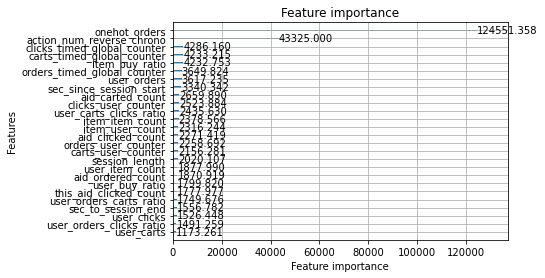

In [61]:
if params.get('train_model') != False:
    from lightgbm import plot_importance
    for i, item in enumerate(ranker):
        print(f'ranker_{i}')
        if model['model'] == LGBMRanker: plot_importance(item)

ranker_0


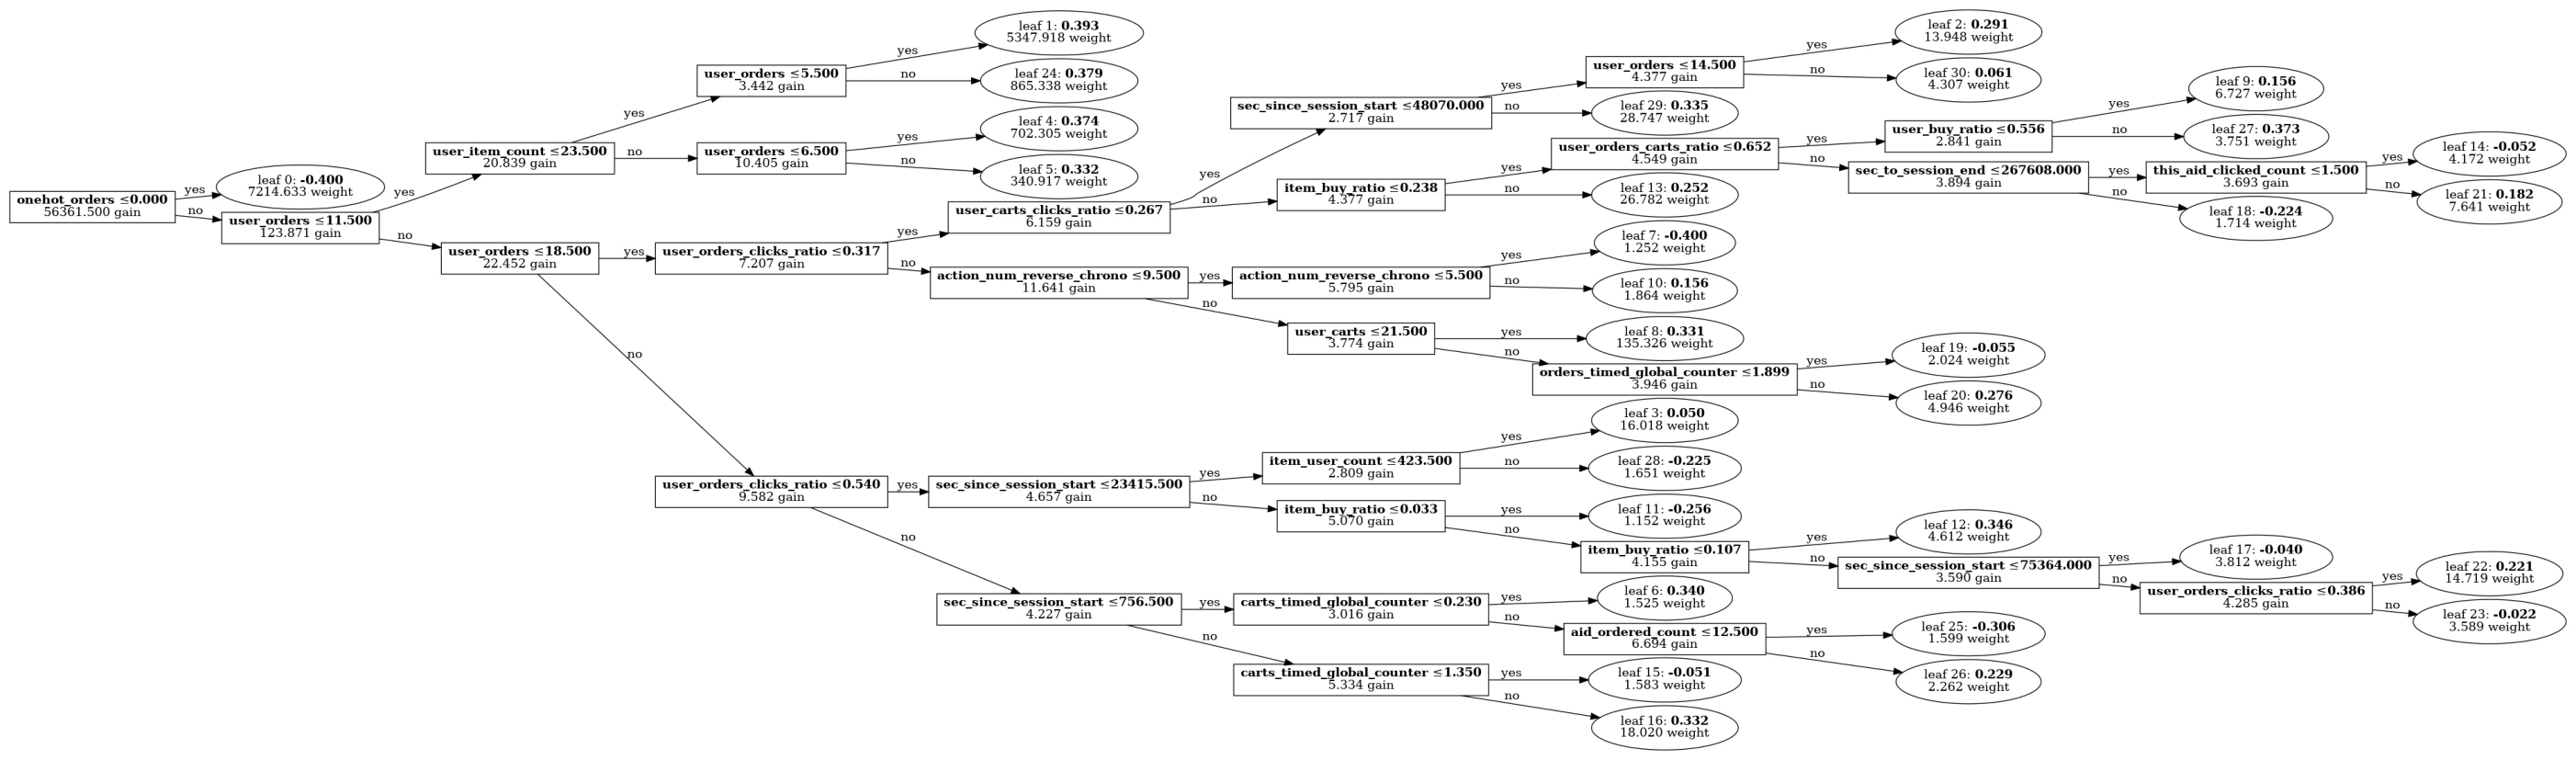

In [62]:
if params.get('train_model') != False:
    from lightgbm import plot_tree
    for i, item in enumerate(ranker):
        print(f'ranker_{i}')
        if model['model'] == LGBMRanker: plot_tree(item, figsize=(50, 50), show_info=['split_gain', 'leaf_weight'])

In [63]:
if params.get('train_model') != False and model.get('show_metric'):
    from lightgbm import plot_metric
    import matplotlib.pyplot as plt

    cols = 3
    labels = 6
    metric = 'ndcg'
    
    if params['model'] == LGBMRanker: 
        i, j = 0, 0
        r = round(labels / cols)
        _, ax = plt.subplots(r, cols, figsize=(64/cols, 5*r))
        for l in range(0, labels):
            qx = ax[j] if r == 1 else ax[i, j]
            plot_metric(ranker, xlabel='Iterations', ylabel=f'{metric}@{l}', ax=qx)
            j = j + 1
            i = i + 1 if j == cols else i
            j = 0 if j == cols else j

# * Реранк *

In [11]:
# -- загружаем модели --
predicter = []
for i in range(0, 3 if params.get('force_ranking') else 1):
    predicter.append(lgb.Booster(model_file=f'/kaggle/working/models/model_0_e0_session_aid_more_2.lgb'))
display(predicter)

In [12]:
# -- получаем названия фич --
features, __ = callPipeline(None, [sessionPipline, aidPipline, session_aidPipline])
if SHOW: print(features)

['session_length', 'user_item_count', 'user_buy_ratio', 'user_clicks', 'user_carts', 'user_orders', 'user_carts_clicks_ratio', 'user_orders_carts_ratio', 'user_orders_clicks_ratio', 'clicks_user_counter', 'carts_user_counter', 'orders_user_counter', 'clicks_timed_global_counter', 'carts_timed_global_counter', 'orders_timed_global_counter', 'aid_clicked_count', 'aid_carted_count', 'aid_ordered_count', 'item_item_count', 'item_user_count', 'item_buy_ratio', 'this_aid_clicked_count', 'this_aid_carted_count', 'this_aid_ordered_count', 'sec_to_session_end', 'sec_since_session_start', 'action_num_reverse_chrono', 'onehot_clicks', 'onehot_carts', 'onehot_orders']


In [13]:
%%time
# -- делаем реранк --
# ~ 20m (orders candidates)
for i in range(0, params['chunks']):
    train = pd.read_parquet(f'train_{i}f.parquet')
    s, e = train['session'].min(), train['session'].max()
    print('\r', f'chunk {i+1} of {params["chunks"]} ({s} to {e})')#, end = '   ')
    train['type'] = 2 # костыль для обучения только покупок
    if params.get('use_model') == True:
        tmp = train.to_pandas() if GPU else train
        for j, item in enumerate(predicter):
            scores = item.predict(tmp[features])
            train['score'] = scores.astype('float32')
            train[['session', 'type', 'aid', 'score']].to_parquet(f'preds_{i}_r{j}.parquet')
    else:
        train['score'] = train.groupby(['session', 'type']).cumcount(ascending=False).astype('uint16')
        for j in range(0, 3 if params.get('force_ranking') else 1):
            train[['session', 'type', 'aid', 'score']].to_parquet(f'preds_{i}_r{j}.parquet')
    if SHOW and i == params['chunks'] -1: display(train.head(4))
    #del train; gc.collect()

 chunk 1 of 10 (11098528 to 11278652)
 chunk 2 of 10 (11278653 to 11458777)
 chunk 3 of 10 (11458778 to 11638902)
 chunk 4 of 10 (11638903 to 11819027)
 chunk 5 of 10 (11819028 to 11999152)
 chunk 6 of 10 (11999153 to 12179277)
 chunk 7 of 10 (12179278 to 12359402)
 chunk 8 of 10 (12359403 to 12539527)
 chunk 9 of 10 (12539528 to 12719652)
 chunk 10 of 10 (12719653 to 12899778)


,session,aid,clicks_user_counter,carts_user_counter,orders_user_counter,clicks_timed_global_counter,carts_timed_global_counter,orders_timed_global_counter,aid_clicked_count,aid_carted_count,...,this_aid_carted_count,this_aid_ordered_count,sec_to_session_end,sec_since_session_start,action_num_reverse_chrono,bought_in_session,onehot_clicks,onehot_carts,onehot_orders,score
0,12719653,1022566,6476,1468,626,1181.120483,222.917664,75.473892,11541,2023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.565434
1,12719653,544144,4431,1057,409,946.068298,174.283127,48.839359,8280,1522,...,1.0,1.0,0.0,202.0,5.0,1.0,0.0,0.0,1.0,2.981025
2,12719653,166037,7970,1868,777,1580.957886,293.008026,87.640564,14901,2687,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.925653
3,12719653,102416,1127,346,166,230.200806,56.987953,25.953815,1883,436,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.963387


CPU times: user 48min 14s, sys: 3min, total: 51min 14s
Wall time: 15min 40s


In [14]:
%%time
# -- составляем предсказание --
# ~ 5m (orders candidates)
predictions = pd.DataFrame()
for i in range(0, params['chunks']):
    for j in range(0, 3 if params.get('force_ranking') else 1):
        preds = pd.read_parquet(f'preds_{i}_r{j}.parquet')[['session', 'type', 'aid', 'score']]
        preds.drop_duplicates(['session', 'aid', 'type'], inplace=True)
        s, e = preds['session'].min(), preds['session'].max()
        print('\r', f'chunk {i+1} of {params["chunks"]} ({s} to {e})')#, end = '   ')
        preds = preds.sort_values(['session', 'type', 'score'], ascending=False)[['session', 'type', 'aid']]
        if GPU: preds = preds.to_pandas()
        preds = preds.groupby(['session', 'type']).agg(labels=('aid', lambda x: list(dict.fromkeys(x)))).reset_index()
        if GPU: preds = pd.from_pandas(preds)
        predictions = pd.concat([predictions, preds]).astype({'type':'uint8'})
predictions.to_parquet('predictions.parquet', index=False)
if SHOW: display(predictions.sort_values(['session', 'type']).head(4), predictions.shape)

 chunk 1 of 10 (11098528 to 11278652)
 chunk 2 of 10 (11278653 to 11458777)
 chunk 3 of 10 (11458778 to 11638902)
 chunk 4 of 10 (11638903 to 11819027)
 chunk 5 of 10 (11819028 to 11999152)
 chunk 6 of 10 (11999153 to 12179277)
 chunk 7 of 10 (12179278 to 12359402)
 chunk 8 of 10 (12359403 to 12539527)
 chunk 9 of 10 (12539528 to 12719652)
 chunk 10 of 10 (12719653 to 12899778)


,session,type,labels
0,11098528,2,"[11830, 756588, 822934, 198496, 1182614, 17646..."
1,11098529,2,"[122792, 1105029, 258596, 1321806, 347486, 182..."
2,11098530,2,"[409236, 666262, 832192, 1653994, 237586, 1216..."
3,11098531,2,"[1365569, 1271998, 1728212, 396199, 452188, 18..."


(1801251, 3)

CPU times: user 6min 12s, sys: 1min 7s, total: 7min 19s
Wall time: 7min 7s


# * Local metrics *

In [15]:
%%time
# ~ 2s
#predictions = pd.read_parquet('predictions.parquet')
#if FILL: predictions = fillEvents(predictions, clone=True)
#if SHOW: display(predictions.sort_values(['session', 'type']).head(4), predictions.shape)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs


In [16]:
%%time
# ~ 3s
if LOCAL: df_true = loadTestLabels(path='/kaggle/input/otto-train-and-test-data-for-local-validation/', p=1.0)
if SHOW and LOCAL: display(df_true.sort_values(['session', 'type']).head(4), df_true.shape)

,session,type,labels
0,11098528,0,[1679529]
1,11098528,1,[1199737]
2,11098528,2,"[990658, 950341, 1462506, 1561739, 907564, 369..."
3,11098529,0,[1105029]


(2212692, 3)

CPU times: user 2.26 s, sys: 760 ms, total: 3.02 s
Wall time: 3.08 s


In [17]:
%%time
# ~ 1m 15s
# Локальная метрика
if LOCAL: 
    localMetrics(predictions, df_true, recall=True)

100%|██████████| 2212692/2212692 [01:01<00:00, 35820.52it/s]


--------------------------------------------------
0.417 = 0.000 + 0.000 + 0.417
score: 0.416899295570103
--------------------------------------------------
0.417 = 0.000 + 0.000 + 0.417
recall: 0.4169050408071419
CPU times: user 1min 47s, sys: 2.33 s, total: 1min 50s
Wall time: 1min 50s


# * Submission *

In [15]:
#predictions = pd.read_parquet('predictions.parquet')
#if SHOW: display(predictions.head(4))

In [16]:
%%time
# 1m 40s
submission = setSubmission(predictions)
submission.to_csv('submission.csv', index=False)
if SHOW: display(submission.head(4))

 19%|█▉        | 338702/1801251 [00:11<00:49, 29671.50it/s]


KeyboardInterrupt: 

In [17]:
pd.DataFrame().to_csv('free_df.csv')